# Variational Mean-Field Inference with ARD
**Author:** Harshad Dahake

**Context:** Approximate Inference Coursework (Gatsby Unit)

### Description
Implementation of **Variational Inference (VI)** using the Mean-Field approximation to recover latent features from high-dimensional data.

**Key Concepts:**
* **Automatic Relevance Determination (ARD):** Learning a sparse prior to automatically prune irrelevant latent dimensions (Structure Learning).
* **Mean-Field Approximation:** Deriving the update equations $q(z_i) \propto \exp(\mathbb{E}_{-q_i}[\ln p(x, z)])$ for factorized posteriors.
* **Evidence Lower Bound (ELBO):** Tracking the ELBO to monitor convergence of the approximate posterior to the true posterior.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.distributions as dist

In [2]:
N=400  # number of data points - you can increase this if you want to
       # learn better features (but it will take longer).
D=16   # dimensionality of the data

np.random.seed(0)

# Define the basic shapes of the features

m1 = [0, 0, 1, 0,
      0, 1, 1, 1,
      0, 0, 1, 0,
      0, 0, 0, 0]

m2 = [0, 1, 0, 0,
      0, 1, 0, 0,
      0, 1, 0, 0,
      0, 1, 0, 0]

m3 = [1, 1, 1, 1,
      0, 0, 0, 0,
      0, 0, 0, 0,
      0, 0, 0, 0]

m4 = [1, 0, 0, 0,
      0, 1, 0, 0,
      0, 0, 1, 0,
      0, 0, 0, 1] 

m5 = [0, 0, 0, 0,
      0, 0, 0, 0,
      1, 1, 0, 0,
      1, 1, 0, 0] 

m6 = [1, 1, 1, 1,
      1, 0, 0, 1,
      1, 0, 0, 1,
      1, 1, 1, 1] 

m7 = [0, 0, 0, 0,
      0, 1, 1, 0,
      0, 1, 1, 0,
      0, 0, 0, 0]

m8 = [0, 0, 0, 1,
      0, 0, 0, 1,
      0, 0, 0, 1,
      0, 0, 0, 1]

nfeat = 8 # number of features
rr = 0.5 + np.random.rand(nfeat, 1) * 0.5 # weight of each feature between 0.5 and 1
mut = np.array([rr[0] * m1, rr[1] * m2, rr[2] * m3, rr[3] * m4, rr[4] * m5,
                rr[5] * m6, rr[6] * m7, rr[7] * m8])
s = np.random.rand(N, nfeat) < 0.3 # each feature occurs with prob 0.3 independently 

# Generate Data - The Data is stored in Y

Y = np.dot(s, mut) + np.random.randn(N, D) * 0.1 # some Gaussian noise is added 

print(f"Y has shape: {Y.shape}")

Y has shape: (400, 16)


In [3]:
def calculate_elbo(X_train, lambda_curr, mu_mean, mu_cov, alphas, pie, sigma_sq):
    """
    Calculates the Evidence Lower Bound (Free Energy) for the 
    Binary Factor Latent Variable Model.
    
    X        : (N, D) - Data
    lambda_curr : (N, K) - Variational parameters (probabilities)
    mu       : (D, K) - Weight matrix
    pie       : (K,)   - Bernoulli priors
    sigma    : scalar - Noise standard deviation
    """
    N, D = X_train.shape
    K = mu_mean.shape[1]

    # JOINT LIKELIHOOD TERMS

    # EXPECTED LOG LIKELIHOOD
    # Diagonal is sum(E[s]), Off-diagonal is E[s_i]*E[s_j], given E[s_i^2] = E[s_i]
    ESS = lambda_curr.T @ lambda_curr
    diag_correction = np.sum(lambda_curr, axis=0) - np.diag(ESS)
    ESS = ESS + np.diag(diag_correction)

    # Term A: Data energy
    term_data = np.sum(X_train**2)

    # Term B: Cross energy # !!! <-- FIX THIS !!!
    term_cross = -2 * np.sum((X_train.T @ lambda_curr) * mu_mean)

    # Term C: Model energy # !!! <-- FIX THIS !!!
    E_muTmu = (mu_mean.T @ mu_mean) + D * mu_cov
    term_model = np.sum(ESS * E_muTmu.T) # using the Trace trick
    
    expected_error = term_data + term_cross + term_model

    log_likelihood = - (N * D / 2) * np.log(2 * np.pi * sigma_sq) - (1 / (2 * sigma_sq)) * expected_error

    # Expected Log Priors (S)
    eps = 1e-10
    pie_clipped = np.clip(pie, eps, 1 - eps)
    log_prior_latents = np.sum(lambda_curr * np.log(pie_clipped) + (1 - lambda_curr) * np.log(1 - pie_clipped))

    # Prior on Weights (mu) - for ARD
    E_mu_sq_norm = np.diag(E_muTmu) 
    log_prior_mu = np.sum(0.5 * D * np.log(alphas / (2 * np.pi)) - 0.5 * alphas * E_mu_sq_norm)

    ## ENTROPY TERMS

    # Entropy of Latents Distributions (Bernoulli)
    lambda_curr_clipped = np.clip(lambda_curr, eps, 1 - eps)
    entropy_latents = -np.sum(lambda_curr_clipped * np.log(lambda_curr_clipped) + (1 - lambda_curr_clipped) * np.log(1 - lambda_curr_clipped))

    # Entropy of Weights Distributions (Multivariate Gaussian)
    sign, weights_logdet = np.linalg.slogdet(mu_cov)
    entropy_weights = 0.5 * D * (K * (1 + np.log(2 * np.pi)) + weights_logdet)

    # CALCULATE TOTAL FREE ENERGY: EXPECTED JOINT LIKELIHOOD + TOTAL ENTROPY
    elbo = log_likelihood + log_prior_latents + log_prior_mu + entropy_latents + entropy_weights
    
    return elbo

In [4]:
def E_step(X_train, mu_mean, mu_cov, pie, sigma_sq, lambda_init, alphas, iterations: int):
    lambda_curr = lambda_init.copy()

    N, D = X_train.shape
    K = mu_mean.shape[1]

    # Expected moment pf weights-squared
    E_muTmu = (mu_mean.T @ mu_mean) + D * mu_cov

    # Threshold for convergence of latent parameters
    threshold_latents = 1e-8

    # Threshold for convergence of ELBO
    threshold_elbo = 1e-6

    # Threshold for convergence of ELBO
    threshold_elbo_drop = -1e-9

    for iter in range(iterations):
        lambda_prev = lambda_curr.copy()
        
        for k in range(K):
            
            ## Calculate coefficients for the various terms dependent on s_k^n

            # 1. Prior term
            eps = 1e-10
            prior_term = np.log( (np.clip(pie[k], eps, 1-eps)) / (np.clip(1 - pie[k], eps, 1-eps)) )

            # 2. X_d term
            data_term = (X_train @ mu_mean[:, k]) / sigma_sq

            # 3. Interations term
            full_interation = lambda_curr @ E_muTmu[:, k]
            other_interactions = full_interation - (lambda_curr[:, k] * E_muTmu[k, k])
            interaction_term = other_interactions / sigma_sq

            # 4. penalty term # !!! <-- FIX THIS !!!
            self_pen_term = 1/(2*sigma_sq) * E_muTmu[k, k]

            lambda_k = prior_term + data_term - interaction_term - self_pen_term

            ## Update q[s_n^k]
            lambda_curr[:, k] = 1.0 / (1.0 + np.exp(-lambda_k))
        
        ## Calculate updated free energy / ELBO
        elbo_prev = -np.inf if iter==0 else elbo_curr.copy()
        elbo_curr = calculate_elbo(X_train, lambda_curr, mu_mean, mu_cov, alphas, pie, sigma_sq)
        
        # Check for increasing ELBO
        issue = True if (iter>0 and ((elbo_curr - elbo_prev) < threshold_elbo_drop)) else False
        if issue:
            print(f"!!! ERROR !!!\nE-step dropped ELBO -- CAUTION !! Check iter #{iter+1} with elbo_curr: {elbo_curr} and elbo_prev: {elbo_prev}\n")
            break
        
        # Check for latent convergence
        if np.max(np.abs(lambda_curr - lambda_prev)) < threshold_latents:
            # print(f"E-step has converged via latents at iter #{iter+1}")
            break
        
        # Check for ELBO convergence
        converged = True if (iter>0 and (( (elbo_curr - elbo_prev)/np.abs(elbo_prev) ) < threshold_elbo)) else False
        if converged:
            # print(f"E-step has converged via ELBO at iter #{iter+1}")
            break

    # print(f"Terminating E-step after {iter+1} steps")

    return lambda_curr, elbo_curr

In [5]:
def M_step(X_train, lambda_curr, alphas, sigma_sq):
    N, D = X_train.shape
    K = lambda_curr.shape[1]
    
    # 1. Compute E[S.T S] (K x K matrix)
    # Diagonal is sum(E[s]), Off-diagonal is E[s_i]*E[s_j], given E[s_i^2] = E[s_i]
    ESS = lambda_curr.T @ lambda_curr
    diag_correction = np.sum(lambda_curr, axis=0) - np.diag(ESS)
    ESS = ESS + np.diag(diag_correction)

    # 2. Covariance Matrix
    mu_prec = (1.0 / sigma_sq) * ESS + np.diag(alphas)
    mu_cov = np.linalg.inv(mu_prec) # KxK matrix

    B = (1.0 / sigma_sq) * (X_train.T @ lambda_curr)
    mu_mean = B @ mu_cov # DxK matrix

    return mu_mean, mu_cov

In [6]:
def hyper_M_step(X_train, mu_mean, mu_cov, lambda_curr):
    N, D = X_train.shape
    K = mu_mean.shape[1]
    
    # Update pie
    pie_new = np.mean(lambda_curr, axis=0)

    # Update alphas (ARD)
    E_mu_sq_norm = np.sum(mu_mean**2, axis=0) + D * np.diag(mu_cov)
    alphas_new = D / E_mu_sq_norm

    ## Update sigma_sq
    
    # Calculate ESS
    ESS = lambda_curr.T @ lambda_curr
    diag_correction = np.sum(lambda_curr, axis=0) - np.diag(ESS)
    ESS = ESS + np.diag(diag_correction)

    # Term 1: Data sum of squares
    term_data = np.sum(X_train**2)

    # Term 2: Cross terms
    term_cross = -2 * np.sum((X_train.T @ lambda_curr) * mu_mean)

    # Term 3: Model term # !!! <-- FIX THIS !!!
    E_muTmu = (mu_mean.T @ mu_mean) + D * mu_cov
    term_model = np.sum(ESS * E_muTmu.T)

    expected_error = term_data + term_cross + term_model
    sigma_sq_new = expected_error / (N * D)

    return pie_new, alphas_new, sigma_sq_new

In [7]:
def VB_EM_algorithm(X_train, K_max, iterations: int):
    N, D = X_train.shape
    
    # Initialisations
    lambda_init = np.random.rand(N, K_max)
    mu_mean = np.random.randn(D, K_max) * 0.01
    mu_cov = np.eye(K_max) * 1e-2
    
    alphas = np.ones(K_max)
    pie = np.ones(K_max) * 0.3
    sigma_sq = 25.0
    max_iters_E = 5000

    elbo_history = []

    # Threshold for convergence of ELBO
    threshold_elbo = 1e-6

    # Threshold for convergence of ELBO
    threshold_elbo_drop = -1e-9

    ## RUN ITERATIVE EM-ALGORITHM (VB)
    lambda_curr = lambda_init.copy()
    for iter in range(iterations):
        # print(f"\n--- xx ----- Now running EM iteration: {iter+1} ----- xx ---")

        if iter < 200:
            sigma_sq = max(sigma_sq, 100.0 * (0.99 ** iter))

        # Variational E-step
        lambda_curr, elbo_curr_E = E_step(X_train, mu_mean, mu_cov, pie, sigma_sq, lambda_curr, alphas, iterations=max_iters_E)

        # Variational M-step
        mu_mean, mu_cov = M_step(X_train, lambda_curr, alphas, sigma_sq)

        # Hyper M-step
        pie, alphas, sigma_sq  = hyper_M_step(X_train, mu_mean, mu_cov, lambda_curr)

        ## Calculate ELBO for issue and converge checks after one complete iteration
        
        # Calculate updated free energy / ELBO
        elbo_prev_M = -np.inf if iter==0 else elbo_curr_M.copy()
        elbo_curr_M = calculate_elbo(X_train, lambda_curr, mu_mean, mu_cov, alphas, pie, sigma_sq) # !!! <-- FIX THIS !!!
        
        elbo_history.append(elbo_curr_M)

        # Check for increasing ELBO
        issue = True if (iter>0 and ( (elbo_curr_M - elbo_prev_M) < threshold_elbo_drop )) else False
        if issue:
            print(f"!!! ERROR !!!\nEM-step dropped ELBO -- CAUTION !! Check iter #{iter+1} with elbo_curr: {elbo_curr_M} and elbo_prev: {elbo_prev_M}\n")
            break
        
        # Check for ELBO convergence
        converged = True if (iter>0 and (( (elbo_curr_M - elbo_prev_M)/np.abs(elbo_prev_M) ) < threshold_elbo)) else False
        if converged:
            # print(f"\nEM has converged at iter #{iter+1}")
            break
    
    print(f"\nTerminating EM algorithm after {iter+1} iterations!")
    return mu_mean, mu_cov, alphas, pie, sigma_sq, lambda_curr, elbo_history


In [8]:
## TRAIN MODEL
X_train = Y.copy()
K_max = 100 # start with 10; want to check performance
max_iters = 10000

mu_mean_final, mu_cov_final, alphas_final, pie_final, sigma_sq_final, lambda_final, elbos = VB_EM_algorithm(X_train, K_max, iterations=max_iters)


Terminating EM algorithm after 1231 iterations!


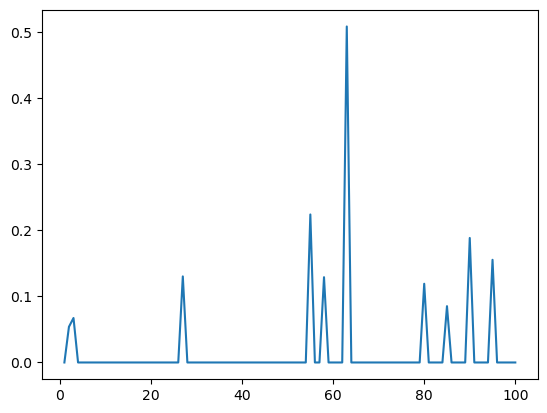

In [9]:
## CHECK RELEVANT FACTORS VISUALLY
plt.figure()
plt.plot(range(1,K_max+1), 1/alphas_final)
plt.show()

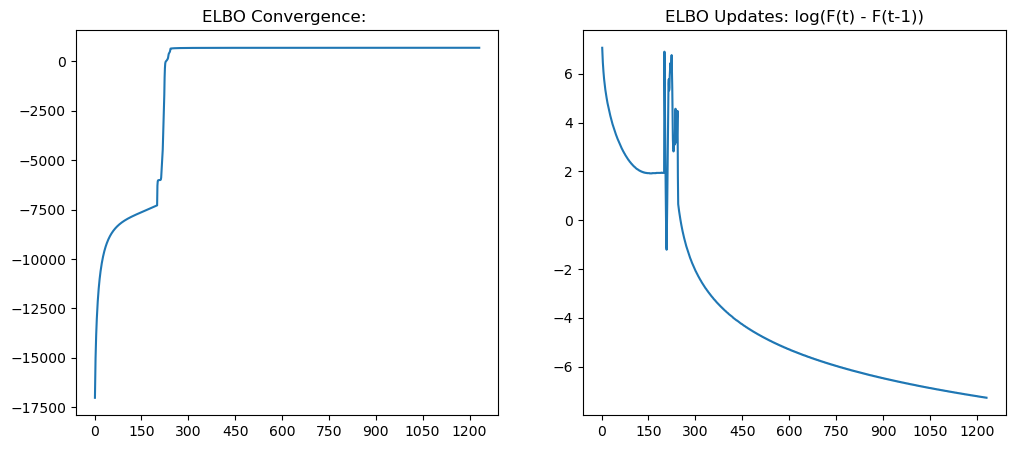

In [10]:
## PLOT ELBO CONVERGENCE PLOTS FOR SANITY CHECKS
from matplotlib.ticker import MaxNLocator

elbo_array = np.array(elbos)

diffs = elbo_array[1:] - elbo_array[:-1]

elbo_diffs = np.log(np.clip(diffs, 1e-12, None))

plt.figure(figsize=(12, 5))

# First Half
plt.subplot(1, 2, 1)
plt.plot(range(1,len(elbo_array)+1),np.round(elbo_array,2))
plt.title("ELBO Convergence: ")
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))

# Second Half
plt.subplot(1, 2, 2)
plt.plot(range(2,len(elbo_array)+1),np.round(elbo_diffs,2))
plt.title("ELBO Updates: log(F(t) - F(t-1))")
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))

plt.show()

In [11]:
## GET EFFECTIVE FACTORS FOR TRAINED MODEL

threshold = 1e3

# Create a boolean mask of active indices
active_indices = alphas_final < threshold

# Filter the weight matrix (D x K_active)
meaningful_mu = mu_mean_final[:, active_indices]

meaningful_lambda = lambda_final[:, active_indices]

meaningful_pie = pie_final[active_indices]

print(f"Original factors: {mu_mean_final.shape[1]}")
print(f"Meaningful factors: {meaningful_mu.shape[1]}\n")

Original factors: 100
Meaningful factors: 10



In [12]:
## FUNCTION TO PLOT WEIGHTS / LEARNED FEATURES
import math

def plot_mu_filters(mu, image_shape=None, title="Learned Filters"):
    """
    mu: Numpy array of shape (D, K) where D is pixels, K is number of filters.
    image_shape: Tuple (height, width). If None, assumes square images.
    """
    D, K = mu.shape
    
    # 1. Determine image dimensions if not provided
    if image_shape is None:
        side = int(np.sqrt(D))
        if side * side != D:
            print(f"Warning: D={D} is not a perfect square. Please specify image_shape.")
        image_shape = (side, side)
        
    # 2. Determine grid layout (rows x cols) for the subplots
    # Try to make it roughly square (e.g., K=10 -> 2x5 or 3x4)
    cols = int(math.ceil(math.sqrt(K)))
    rows = int(math.ceil(K / cols))
    
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))
    fig.suptitle(title, fontsize=16)
    
    # Flatten axes array for easy iteration
    axes_flat = axes.flatten() if K > 1 else [axes]
    
    for k in range(K):
        ax = axes_flat[k]
        
        # 3. Extract and Reshape the k-th filter
        filter_img = mu[:, k].reshape(image_shape)
        
        # 4. Plot
        # 'cmap' can be 'gray', 'viridis', 'plasma', etc.
        # 'interpolation'='nearest' ensures you see the raw pixels clearly
        im = ax.imshow(filter_img, cmap='gray', interpolation='nearest')
        
        ax.set_title(f'Filter {k+1}')
        ax.axis('off') # Hide axes ticks for cleaner look

    # Turn off any unused subplots
    for k in range(K, len(axes_flat)):
        axes_flat[k].axis('off')

    plt.tight_layout()
    plt.show()

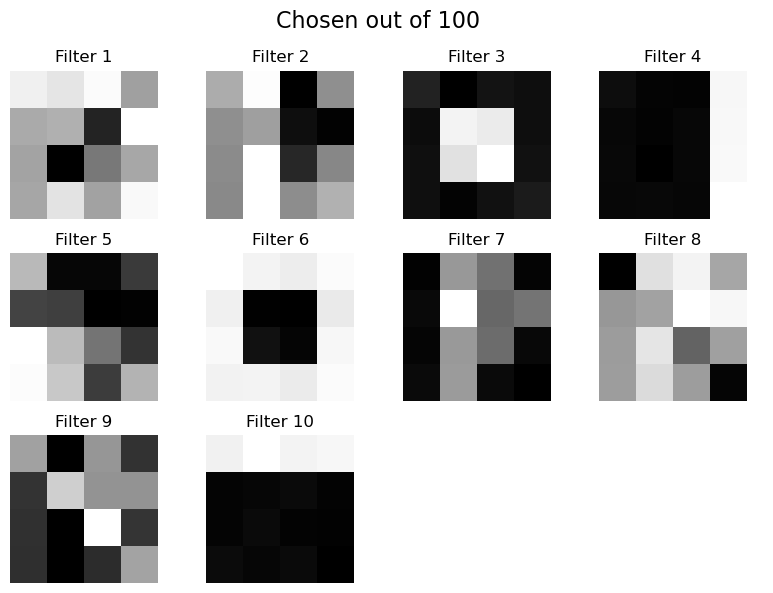

In [13]:
# PLOT WEIGHTS
plot_mu_filters(meaningful_mu, title=f"Chosen out of {K_max}")

In [14]:
## HIGH CONTRACT PLOTTING FOR EASE OF VISUALISATION
def plot_sorted_filters(mu, pie, title="Filters Sorted by Usage (Pie)"):
    pie = pie.flatten()
    
    D, K = mu.shape
    
    # 1. Get indices that would sort 'pie' from Highest to Lowest
    sorted_indices = np.argsort(pie)[::-1]
    
    # 2. Reorder mu and pie
    mu_sorted = mu[:, sorted_indices]
    pie_sorted = pie[sorted_indices]
    
    # 3. Setup Plot
    import math
    cols = int(math.ceil(math.sqrt(K)))
    rows = int(math.ceil(K / cols))
    
    fig, axes = plt.subplots(rows, cols, figsize=(cols*2.5, rows*2.5))
    fig.suptitle(title, fontsize=16)
    axes_flat = axes.flatten()
    
    side = int(np.sqrt(D)) # Assuming square images
    
    for k in range(K):
        ax = axes_flat[k]
        
        # Plot the filter
        filter_img = mu_sorted[:, k].reshape(side, side)
        # Use a diverging colormap (Red-Blue) to see positive vs negative weights clearly
        im = ax.imshow(filter_img, cmap='RdBu_r', interpolation='nearest')
        
        # Add the "Importance" score to the title
        usage_pct = pie_sorted[k] * 100
        ax.set_title(f"Rank {k+1}\nUsage: {usage_pct:.1f}%", fontsize=10)
        ax.axis('off')

    # Hide unused subplots
    for k in range(K, len(axes_flat)):
        axes_flat[k].axis('off')

    plt.tight_layout()
    plt.show()

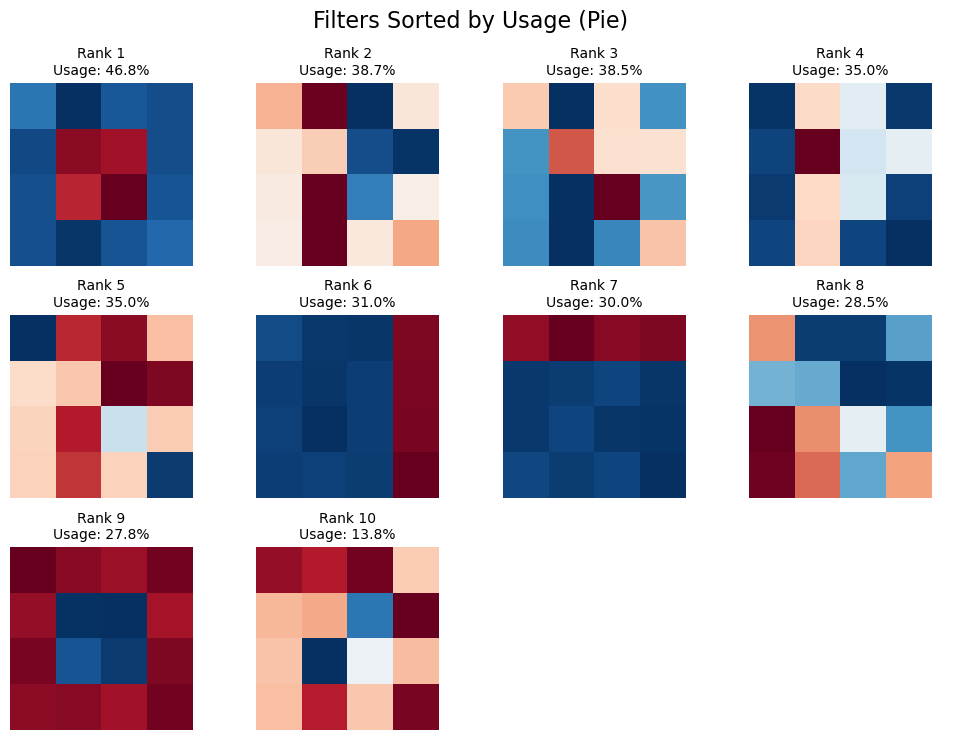

In [15]:
# PLOT
plot_sorted_filters(meaningful_mu, meaningful_pie)

In [16]:
## CHECK sigma_sq (variance/noise) value
np.round(sigma_sq_final,4).item()

0.0187

In [17]:
## 4b - Part 2: VB Free Energy and Effective K vs Iterations for different K_max (max number of factors)

In [18]:
# DEFINE A MODIFIED VB-EM function based on the original one (above) that outputs across-iterations history of free energy AND alphas (precision scale factors)
def VB_EM_algorithm_experiments(X_train, K_max, iterations: int):
    N, D = X_train.shape
    
    # Initialisations
    lambda_init = np.random.rand(N, K_max)
    mu_mean = np.random.randn(D, K_max) * 0.01
    mu_cov = np.eye(K_max) * 1e-2
    
    alphas = np.ones(K_max)
    pie = np.ones(K_max) * 0.3
    sigma_sq = 25.0
    max_iters_E = 5000

    elbo_history = []
    alphas_history = []

    # Threshold for convergence of ELBO
    threshold_elbo = 1e-6

    # Threshold for convergence of ELBO
    threshold_elbo_drop = -1e-9

    ## RUN ITERATIVE EM-ALGORITHM (VB)
    lambda_curr = lambda_init.copy()
    for iter in range(iterations):
        # print(f"\n--- xx ----- Now running EM iteration: {iter+1} ----- xx ---")

        if iter < 200:
            sigma_sq = max(sigma_sq, 100.0 * (0.99 ** iter))

        # Variational E-step
        lambda_curr, elbo_curr_E = E_step(X_train, mu_mean, mu_cov, pie, sigma_sq, lambda_curr, alphas, iterations=max_iters_E)

        # Variational M-step
        mu_mean, mu_cov = M_step(X_train, lambda_curr, alphas, sigma_sq)

        # Hyper M-step
        pie, alphas, sigma_sq  = hyper_M_step(X_train, mu_mean, mu_cov, lambda_curr)

        ## Calculate ELBO for issue and converge checks after one complete iteration
        
        # Calculate updated free energy / ELBO
        elbo_prev_M = -np.inf if iter==0 else elbo_curr_M.copy()
        elbo_curr_M = calculate_elbo(X_train, lambda_curr, mu_mean, mu_cov, alphas, pie, sigma_sq) # !!! <-- FIX THIS !!!
        
        elbo_history.append(elbo_curr_M)
        alphas_history.append(alphas)

        # Check for increasing ELBO
        issue = True if (iter>0 and ( (elbo_curr_M - elbo_prev_M) < threshold_elbo_drop )) else False
        if issue:
            print(f"!!! ERROR !!!\nEM-step dropped ELBO -- CAUTION !! Check iter #{iter+1} with elbo_curr: {elbo_curr_M} and elbo_prev: {elbo_prev_M}\n")
            break
        
        # Check for ELBO convergence
        converged = True if (iter>0 and (( (elbo_curr_M - elbo_prev_M)/np.abs(elbo_prev_M) ) < threshold_elbo)) else False
        if converged:
            # print(f"\nEM has converged at iter #{iter+1}")
            break
    
    print(f"\nTerminating EM algorithm after {iter+1} iterations!")
    return mu_mean, mu_cov, alphas, pie, sigma_sq, lambda_curr, elbo_history, alphas_history


In [19]:
## RUN EXPERIMENTS ON K = {4,5,...,20}

## EMPIRICALLY TEST VALUES OF K

X_train = Y.copy()
sigma = 5.0
max_iters = 1500

K_maxs = (np.linspace(4, 20, 9, dtype=int)).tolist()
print(K_maxs)

threshold = 1e3

final_elbos = []
final_mus = []
final_lambdas = []
final_pies = []
meaningful_factors = []
timeline_elbos = []
timeline_alphas = []

for i, K_max in enumerate(K_maxs):
    print(f"\nDone. Now onto: K_max = {K_max}")
    mu_mean_final, mu_cov_final, alphas_final, pie_final, sigma_sq_final, lambda_final, elbos, alphas = VB_EM_algorithm_experiments(X_train, K_max, iterations=max_iters)
    
    final_elbos.append(elbos[-1])

    # 2. Create a boolean mask of active indices
    active_indices = alphas_final < threshold

    # 3. Filter the weight matrix (D x K_active)
    meaningful_mu = mu_mean_final[:, active_indices]
    final_mus.append(meaningful_mu)

    meaningful_lambda = lambda_final[:, active_indices]
    final_lambdas.append(meaningful_lambda)

    meaningful_pie = pie_final[active_indices]
    final_pies.append(meaningful_pie)

    print(f"For K_max = {K_max}, Original factors: {mu_mean_final.shape[1]}")
    print(f"For K_max = {K_max}, Meaningful factors: {meaningful_mu.shape[1]}\n")

    meaningful_factors.append(meaningful_mu.shape[1])


    ## GET THE FULL TIMELINE HISTORY FOR ELBO AND EFFECTIVE FACTORS
    timeline_elbos.append(elbos)

    # 2. Create a boolean mask of active indices
    alphas_matrix = np.array(alphas)
    active_mask = alphas_matrix < threshold
    effective_k_history = np.sum(active_mask, axis=1)
    timeline_alphas.append(effective_k_history)


[4, 6, 8, 10, 12, 14, 16, 18, 20]

Done. Now onto: K_max = 4

Terminating EM algorithm after 250 iterations!
For K_max = 4, Original factors: 4
For K_max = 4, Meaningful factors: 4


Done. Now onto: K_max = 6

Terminating EM algorithm after 228 iterations!
For K_max = 6, Original factors: 6
For K_max = 6, Meaningful factors: 6


Done. Now onto: K_max = 8

Terminating EM algorithm after 235 iterations!
For K_max = 8, Original factors: 8
For K_max = 8, Meaningful factors: 8


Done. Now onto: K_max = 10

Terminating EM algorithm after 235 iterations!
For K_max = 10, Original factors: 10
For K_max = 10, Meaningful factors: 10


Done. Now onto: K_max = 12

Terminating EM algorithm after 296 iterations!
For K_max = 12, Original factors: 12
For K_max = 12, Meaningful factors: 12


Done. Now onto: K_max = 14

Terminating EM algorithm after 290 iterations!
For K_max = 14, Original factors: 14
For K_max = 14, Meaningful factors: 14


Done. Now onto: K_max = 16

Terminating EM algorithm after 383

In [20]:
## Define function to plot across-iterations history for all K_max values tested within a single plot
def plot_vb_comparison(timeline_elbos, timeline_counts, k_max_values):
    
    # Create two stacked subplots sharing the x-axis
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10), sharex=True)
    
    # Generate distinct colors for each experiment
    cmap = plt.get_cmap('tab10') 
    colors = [cmap(i) for i in np.linspace(0, 1, len(k_max_values))]
    
    for i, k_val in enumerate(k_max_values):
        # Get data for this run
        elbos = timeline_elbos[i]
        counts = timeline_counts[i] 
        
        # Create X-axis based on length of this specific run
        iterations = np.arange(len(elbos))
        
        # Plot ELBO (Top)
        ax1.plot(iterations, elbos, label=f'K_max={k_val}', color=colors[i], linewidth=2, alpha=0.8)
        
        # Plot Effective K (Bottom)
        ax2.plot(iterations, counts, label=f'K_max={k_val}', color=colors[i], linewidth=2, alpha=0.8)

    # --- Formatting Top Plot (ELBO) ---
    ax1.set_ylabel('VB Free Energy (ELBO)', fontsize=12, fontweight='bold')
    ax1.set_title('Convergence of Free Energy across K_max', fontsize=14)
    ax1.grid(True, linestyle='--', alpha=0.5)
    ax1.legend(loc='lower right')

    # --- Formatting Bottom Plot (Effective K) ---
    ax2.set_ylabel('Effective Factors (K)', fontsize=12, fontweight='bold')
    ax2.set_xlabel('Iteration', fontsize=12, fontweight='bold')
    ax2.set_title('Pruning of Factors over Time', fontsize=14)
    ax2.grid(True, linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    plt.show()

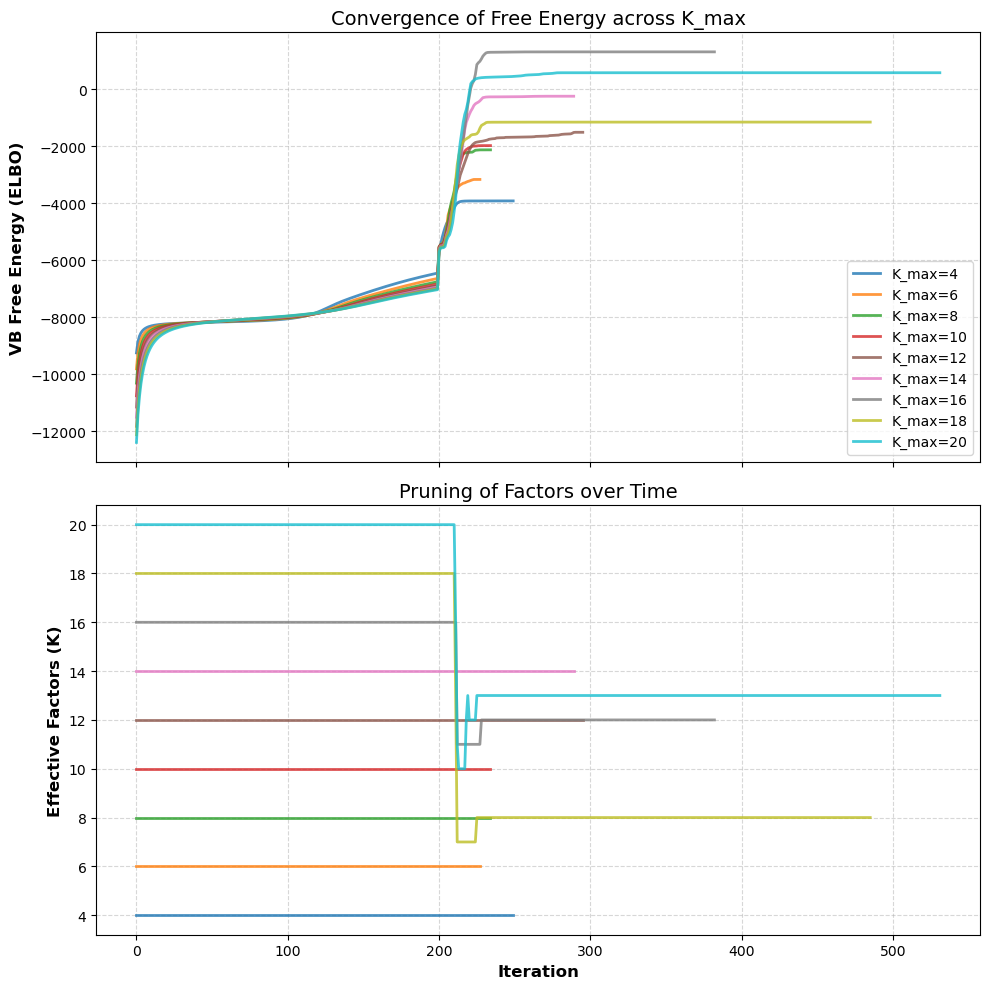

In [21]:
# PLOT FOR COMPARISON
plot_vb_comparison(timeline_elbos, timeline_alphas, K_maxs)